In [3]:
import pickle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Model Definition
P3 = 128
# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # Text MSM Layers
    self.bigru_text = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_text = keras.layers.Dense(128, activation='relu')
    self.msl_2_text = keras.layers.Dense(P3, activation='relu')

  def __call__(self, text_input):
    # Text MSM
    bigru_text_output = self.bigru_text(text_input)
    msl_l1_text = self.msl_1_text(bigru_text_output)
    text_msm_output = self.msl_2_text(msl_l1_text)

    return text_msm_output


# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 7
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, text_msm_output):
    output_l1 = self.layer_1(text_msm_output)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# deep dense fusion network with multimodal residual (DFMR)
class SA_Model(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.text_input = keras.Input(shape=(50, 300))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    text_msm_output = self.msm(self.text_input)
    output = self.scm(text_msm_output)    
    # model definition
    model = keras.Model(inputs=[self.text_input], outputs=output)
    return model


sa_model = SA_Model()
model = sa_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │       857,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 966,759 (3.69 MB)

 Trainable params: 966,759 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [6]:
# with open('/content/drive/MyDrive/Colab Notebooks/Multimodal Sentiment Analysis/mosi_data.pkl', 'rb') as fp:
#   data = pickle.load(fp)

with open('../../datasets/MOSI/mosi_data.pkl', 'rb') as fp:
  data = pickle.load(fp)

In [7]:
def convertLabels(label):
  result = 0
  if label < -2:
    result = -3
  elif -2 <= label and label < -1:
    result = -2
  elif -1 <= label and label < 0:
    result = -1
  elif 0 <= label and label <= 0:
    result = 0
  elif 0 < label and label <= 1:
    result = 1
  elif 1 < label and label <= 2:
    result = 2
  elif label > 2:
    result = 3
  rep = {
    -3 : [1., 0., 0., 0., 0., 0., 0.],
    -2 : [0., 1., 0., 0., 0., 0., 0.],
    -1 : [0., 0., 1., 0., 0., 0., 0.],
    0 : [0., 0., 0., 1., 0., 0., 0.],
    1 : [0., 0., 0., 0., 1., 0., 0.],
    2 : [0., 0., 0., 0., 0., 1., 0.],
    3 : [0., 0., 0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[result])

def prepare_data(type):
  text_input = tf.convert_to_tensor(data[type]['text'])
  labels = [convertLabels(element) for element in data[type]['labels'][:, 0][:, 0]]
  labels = np.array(labels, dtype=np.float32)
  return text_input, labels

In [8]:
train_text_input, train_labels = prepare_data('train')
valid_text_input, valid_labels = prepare_data('valid')

training_dataset = [train_text_input]
validation_data = ([valid_text_input], valid_labels)

test_text_input, test_labels = prepare_data('test')
test_dataset = [test_text_input]

In [9]:
print(f"Training Input Shape of Text Modality: {train_text_input.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

Training Input Shape of Text Modality: (1284, 50, 300)
Training Labels Shape: (1284, 7)


In [10]:
print(f"Type of Training Input of Text Modality: {type(train_text_input)}")
print(f"Type of Training Labels: {type(train_labels)}")

Type of Training Input of Text Modality: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of Training Labels: <class 'numpy.ndarray'>


In [11]:
epochs = 100
history = model.fit(training_dataset, train_labels, validation_data=validation_data, epochs=epochs)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 306ms/step - accuracy: 0.0000e+00 - loss: 0.2378 - val_accuracy: 0.0000e+00 - val_loss: 0.2489
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.0000e+00 - loss: 0.2309 - val_accuracy: 0.0000e+00 - val_loss: 0.2489
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.0000e+00 - loss: 0.2345 - val_accuracy: 0.0000e+00 - val_loss: 0.2489
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - accuracy: 0.0000e+00 - loss: 0.2319 - val_accuracy: 0.0000e+00 - val_loss: 0.2489
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.0000e+00 - loss: 0.2348 - val_accuracy: 0.0000e+00 - val_loss: 0.2489
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.0000e+00 - loss: 0.2322 - val_accuracy: 0.0000e+00 - val_loss: 0.2489
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.0000e+00 - loss: 0.2318 - val_accuracy: 0.0000e+00 - val_loss: 0.2489
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━

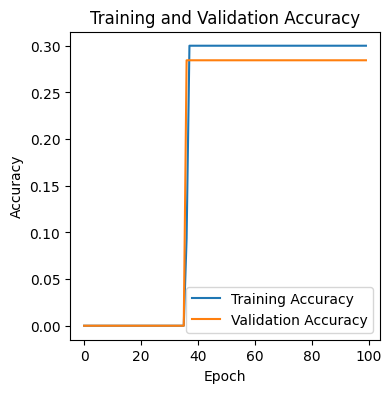

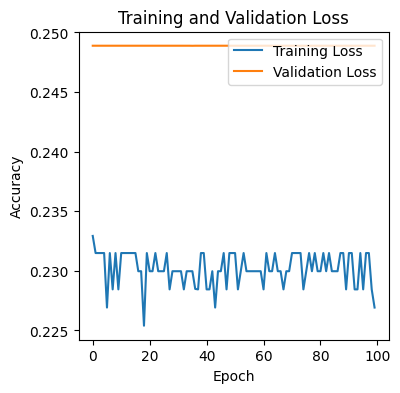

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, test_labels)
print("test loss, test acc:", results)

Evaluate on test data
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.2776 - loss: 0.2366
test loss, test acc: [0.23654915392398834, 0.283631831407547]
